# Gold Price Prediction
## Implementation with Tensorflow on AWS

In [100]:
%%capture
# !pip install yfinance

## Set up the environment

In [101]:
import os
import boto3
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name
training_data_uri = "s3://gold-prediction-labibai-diego/data/"

In [102]:
# TensorFlow 2.3.1 script
!pygmentize 'gold_prediction.py'

import os
import json
import time
import argparse
import numpy as np

# Training & Testing
import tensorflow as tf
from tensorflow import keras

def _load_training_data(base_dir):
    """Load training data"""
    x_train = np.load(os.path.join(base_dir, 'train/X_train.npy'))
    y_train = np.load(os.path.join(base_dir, 'train/y_train.npy'))
    return x_train, y_train

def _load_validation_data(base_dir):
    """Load validation data"""
    x_val = np.load(os.path.join(base_dir, 'val/X_val.npy'))
    y_val = np.load(os.path.join(base_dir, 'val/y_val.npy'))
    return x_val, y_val

def _load_testing_data(base_dir):
    """Load testing data"""
    x_test = np.load(os.path.join(base_dir, 'test/X_test.npy'))
    y_test = np.load(os.path.join(base_dir, 'test/y_test.npy'))
    return x_test, y_test

def model(X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, batch_size=128, optimizer='adam', activation='relu', conv_filters=64, kernel_size=3, window_size=64, n_time_features=4, seq_ne

In [103]:
from sagemaker.tensorflow import TensorFlow

gold_pred_estimator = TensorFlow(entry_point='gold_prediction.py',
                             role=role,
                             instance_count=2,
                             instance_type='ml.m5.4xlarge',
                             framework_version='2.3.1',
                             py_version='py37',
                             distribution={'parameter_server': {'enabled': True}})

In [104]:
gold_pred_estimator.fit(training_data_uri)

2022-06-10 03:34:39 Starting - Starting the training job...
2022-06-10 03:35:03 Starting - Preparing the instances for trainingProfilerReport-1654832079: InProgress
......
2022-06-10 03:36:03 Downloading - Downloading input data...
2022-06-10 03:36:23 Training - Downloading the training image..2022-06-10 03:36:50.107657: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-06-10 03:36:50.112079: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-06-10 03:36:50.282199: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-06-10 03:36:52,866 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-06-10 03:36:52,873 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-0

## Deploy the model to AWS Lambda

In [105]:
gold_pred_estimator.model_data

's3://sagemaker-ap-south-1-690675516063/tensorflow-training-2022-06-10-03-34-38-862/output/model.tar.gz'

In [106]:
!aws s3 cp $gold_pred_estimator.model_data ./container/model/

download: s3://sagemaker-ap-south-1-690675516063/tensorflow-training-2022-06-10-03-34-38-862/output/model.tar.gz to container/model/model.tar.gz


In [107]:
!tar -xvf ./container/model/model.tar.gz

00000001/
00000001/assets/
00000001/saved_model.pb
00000001/variables/
00000001/variables/variables.index
00000001/variables/variables.data-00000-of-00001


In [108]:
!saved_model_cli show --all --dir ./00000001/


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, -1, 64, 7)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '__call__

## Building and registering the container

In [139]:
%%sh

# The name of our lambda function
lambda_function_name=tensorflow-gold-prediction-inference-docker-lambda

cd container

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to ap-south-1 if none defined)
region=$(aws configure get region)
region=${region:-ap-south-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${lambda_function_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${lambda_function_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${lambda_function_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${lambda_function_name} .
docker tag ${lambda_function_name} ${fullname}

docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  16.09MB
Step 1/7 : FROM public.ecr.aws/lambda/python:3.7
 ---> 0002aba15263
Step 2/7 : COPY requirements.txt ./requirements.txt
 ---> Using cache
 ---> 9349007f08cb
Step 3/7 : RUN pip install -r requirements.txt
 ---> Using cache
 ---> 6d793b8c94ef
Step 4/7 : COPY ./model/model.tar.gz .
 ---> Using cache
 ---> 0104bd711b88
Step 5/7 : RUN tar -xzf model.tar.gz
 ---> Using cache
 ---> 338645ac161a
Step 6/7 : COPY ./app/app.py   ./
 ---> 8ab84cb0015f
Step 7/7 : CMD ["app.handler"]
 ---> Running in 5b9c85d6c7f5
Removing intermediate container 5b9c85d6c7f5
 ---> 49a38661bd43
Successfully built 49a38661bd43
Successfully tagged tensorflow-gold-prediction-inference-docker-lambda:latest
The push refers to repository [690675516063.dkr.ecr.ap-south-1.amazonaws.com/tensorflow-gold-prediction-inference-docker-lambda]
8e48540c5c85: Preparing
2cd895200408: Preparing
233d2a2962d1: Preparing
506039446a05: Preparing
33ef584982be: Preparing
c04aace1

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [140]:
import boto3

client = boto3.client('sts')
account_id = client.get_caller_identity()['Account']

my_session = boto3.session.Session()
region = my_session.region_name

lambda_function_name = 'tensorflow-gold-prediction-inference-docker-lambda'

ecr_image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account_id, region, lambda_function_name)

print(ecr_image)

690675516063.dkr.ecr.ap-south-1.amazonaws.com/tensorflow-gold-prediction-inference-docker-lambda:latest


## Create AWS Lambda IAM Role

In [141]:
iam = boto3.Session().client(service_name='iam', region_name=region)

In [142]:
iam_lambda_role_name = 'TensorFlow_GoldPred_Lambda'

In [143]:
iam_lambda_role_passed = False

In [144]:
assume_role_policy_doc = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": "lambda.amazonaws.com"
            },
            "Action": "sts:AssumeRole"
        }
    ]
}

In [145]:
import time
import json

from botocore.exceptions import ClientError

try:
    iam_role_lambda = iam.create_role(
        RoleName=iam_lambda_role_name,
        AssumeRolePolicyDocument=json.dumps(assume_role_policy_doc),
        Description='TensorFlow Gold Prediction Lambda Role'
    )
    print('Role succesfully created.')
    iam_lambda_role_passed = True
except ClientError as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        iam_role_lambda = iam.get_role(RoleName=iam_lambda_role_name)
        print('Role already exists. This is OK.')
        iam_lambda_role_passed = True
    else:
        print('Unexpected error: %s' % e)
        
time.sleep(30)

Role already exists. This is OK.


In [146]:
iam_role_lambda_name = iam_role_lambda['Role']['RoleName']
print('Role Name: {}'.format(iam_role_lambda_name))

Role Name: TensorFlow_GoldPred_Lambda


In [147]:
iam_role_lambda_arn = iam_role_lambda['Role']['Arn']
print('Role ARN: {}'.format(iam_role_lambda_arn))

Role ARN: arn:aws:iam::690675516063:role/TensorFlow_GoldPred_Lambda


## Create AWS Lambda IAM Policy

In [148]:
lambda_policy_doc = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "UseLambdaFunction",
            "Effect": "Allow",
            "Action": [
                "lambda:InvokeFunction",
                "lambda:GetFunctionConfiguration"
            ],
            "Resource": "arn:aws:lambda:{}:{}:function:*".format(region, account_id)
        },
        {
            "Effect": "Allow",
            "Action": "cloudwatch:*",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "arn:aws:logs:{}:{}:*".format(region, account_id)
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:{}:{}:log-group:/aws/lambda/*".format(region, account_id)
        },
        {
            "Effect": "Allow",
            "Action": "s3:*",
            "Resource": "*"
        }
    ]
}


In [149]:
print(json.dumps(lambda_policy_doc, indent=4, sort_keys=True, default=str))

{
    "Statement": [
        {
            "Action": [
                "lambda:InvokeFunction",
                "lambda:GetFunctionConfiguration"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:lambda:ap-south-1:690675516063:function:*",
            "Sid": "UseLambdaFunction"
        },
        {
            "Action": "cloudwatch:*",
            "Effect": "Allow",
            "Resource": "*"
        },
        {
            "Action": "logs:CreateLogGroup",
            "Effect": "Allow",
            "Resource": "arn:aws:logs:ap-south-1:690675516063:*"
        },
        {
            "Action": [
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:logs:ap-south-1:690675516063:log-group:/aws/lambda/*"
        },
        {
            "Action": "s3:*",
            "Effect": "Allow",
            "Resource": "*"
        }
    ],
    "Version": "2012-10-17"
}


In [150]:
import time

response = iam.put_role_policy(
    RoleName=iam_role_lambda_name,
    PolicyName='TensorFlow_GoldPred_Lambda_Policy',
    PolicyDocument=json.dumps(lambda_policy_doc)
)

time.sleep(30)

## Create The Lambda Function

In [151]:
iam_role_lambda_arn

'arn:aws:iam::690675516063:role/TensorFlow_GoldPred_Lambda'

In [152]:
import time
client = boto3.client('lambda')

try: 
    response = client.create_function(
        FunctionName=lambda_function_name,
        Role=iam_role_lambda_arn,
        Code={
            'ImageUri': ecr_image
        },
        PackageType='Image',
        Timeout=120,
        MemorySize=1536,
    )
    print('Creating Lambda Function {}. Please wait while it is being created.'.format(lambda_function_name))
    time.sleep(90)
    print('Lambda Function {} successfully created.'.format(lambda_function_name))
except ClientError as e:
    if e.response['Error']['Code'] == 'ResourceConflictException':
        print('Lambda Function {} already exists. This is OK.'.format(lambda_function_name))
    else:
        print('Error: {}'.format(e))


Creating Lambda Function tensorflow-gold-prediction-inference-docker-lambda. Please wait while it is being created.
Lambda Function tensorflow-gold-prediction-inference-docker-lambda successfully created.


## Prepare test event for the Lambda function

In [153]:
event = {
      "bucket": 'gold-prediction-labibai-diego',
      "prefix": 'data/test/',
      "file": 'X_test.npy'
    }
json.dumps(event)

'{"bucket": "gold-prediction-labibai-diego", "prefix": "data/test/", "file": "X_test.npy"}'

## Invoke the Lambda function

In [154]:
response = client.invoke(
    FunctionName=lambda_function_name,
    InvocationType='RequestResponse',
    Payload=json.dumps(event)
)

In [155]:
print(response)

{'ResponseMetadata': {'RequestId': '38fe4ce2-3840-4b57-aa98-95ebef898ba7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 10 Jun 2022 04:15:08 GMT', 'content-type': 'application/json', 'content-length': '3115', 'connection': 'keep-alive', 'x-amzn-requestid': '38fe4ce2-3840-4b57-aa98-95ebef898ba7', 'x-amzn-remapped-content-length': '0', 'x-amz-executed-version': '$LATEST', 'x-amzn-trace-id': 'root=1-62a2c52e-2d5ffe9d45ba662f171d62c8;sampled=0'}, 'RetryAttempts': 1}, 'StatusCode': 200, 'ExecutedVersion': '$LATEST', 'Payload': <botocore.response.StreamingBody object at 0x7f9dc336f5c0>}


In [156]:
print('HTTPStatusCode: {}'.format(response['ResponseMetadata']['HTTPStatusCode']))

HTTPStatusCode: 200


In [157]:
print(response['ResponseMetadata'])

{'RequestId': '38fe4ce2-3840-4b57-aa98-95ebef898ba7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 10 Jun 2022 04:15:08 GMT', 'content-type': 'application/json', 'content-length': '3115', 'connection': 'keep-alive', 'x-amzn-requestid': '38fe4ce2-3840-4b57-aa98-95ebef898ba7', 'x-amzn-remapped-content-length': '0', 'x-amz-executed-version': '$LATEST', 'x-amzn-trace-id': 'root=1-62a2c52e-2d5ffe9d45ba662f171d62c8;sampled=0'}, 'RetryAttempts': 1}


In [158]:
response = json.loads(response["Payload"].read())

In [160]:
predictions = json.loads(response['body'])

In [161]:
predictions

[0.8972193002700806,
 0.9002951979637146,
 0.8998733162879944,
 0.8968062400817871,
 0.8978168368339539,
 0.8976240158081055,
 0.8961628675460815,
 0.8956711292266846,
 0.8963004946708679,
 0.8963584899902344,
 0.895795464515686,
 0.8922557830810547,
 0.8974143266677856,
 0.8967915177345276,
 0.8973672389984131,
 0.8938314914703369,
 0.8962948322296143,
 0.8926149606704712,
 0.8943857550621033,
 0.8936711549758911,
 0.8969364762306213,
 0.8937742710113525,
 0.8970955014228821,
 0.8973418474197388,
 0.9019815325737,
 0.9015997648239136,
 0.9019085764884949,
 0.9040981531143188,
 0.9065208435058594,
 0.9080137014389038,
 0.9057367444038391,
 0.906731367111206,
 0.9084020853042603,
 0.9100446701049805,
 0.9104284048080444,
 0.9087089896202087,
 0.9134781360626221,
 0.9103679656982422,
 0.9140761494636536,
 0.9084136486053467,
 0.910273015499115,
 0.9078357219696045,
 0.9076907634735107,
 0.9041702151298523,
 0.9037286639213562,
 0.9058926701545715,
 0.9018824100494385,
 0.9031040668487549

Let's download the training labels to use it to evaluate the model.

In [162]:
import numpy as np

!aws --region {region} s3 cp s3://gold-prediction-labibai-diego/data/test/y_test.npy y_test.npy

y_test = np.load('y_test.npy')

download: s3://gold-prediction-labibai-diego/data/test/y_test.npy to ./y_test.npy


RMSE : 0.04932286045107722
Correlation : -0.2737874437390106


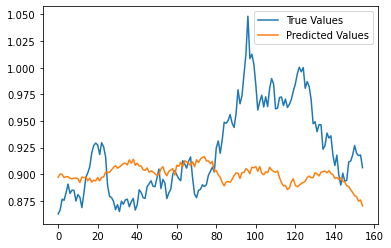

In [166]:
import matplotlib.pyplot as plt

y_hat = np.array(predictions).reshape(-1, 1)

print('RMSE :', np.sqrt(np.mean(np.square(y_test - y_hat))))
print('Correlation :', np.corrcoef(y_test.squeeze(1), y_hat.squeeze(1))[1, 0])
plt.plot(y_test, label = 'True Values')
plt.plot(y_hat, label = 'Predicted Values')
plt.legend()
plt.show()

## Delete the Lambda function

In [ ]:
response = client.delete_function(
    FunctionName=lambda_function_name,
)

In [ ]:
print(response)

# Data & Model Design

## Collect Data

We scrap the value for gold from Yahoo Finace:

In [ ]:
stocks = [
    {"stock_name": "Standard and Poor's (S&P) 500 index", "stock_ticker": "^GSPC", "feature": True},
    {"stock_name": "Dow Jones Industrial Average", "stock_ticker": "^DJI", "feature": True},
    {"stock_name": "Crude Oil", "stock_ticker": "CL=F", "feature": True},
    {"stock_name": "Gold Miners ETF", "stock_ticker": "GLD", "target": "GLD Adj Close", "feature": False}
]

# # Save example for server
# file_path = "stocks.json"
# json.dump(stocks, codecs.open(file_path, 'w', encoding='utf-8'), 
#           separators=(',', ':'), 
#           sort_keys=True, 
#           indent=4)

# Lets have a look at the Gold Miners ETF information
gld = yf.Ticker(stocks[-1]["stock_ticker"])
# gld.info

In [ ]:
# Now lets collect the data from the companies
data = yf.download(
    " ".join([obs['stock_ticker'] for obs in stocks]), 
    start="2000-01-01",
    end="2022-06-01",
    group_by='ticker')

data.columns = data.columns.map('_'.join)
data.columns = [c.lower() for c in data.columns]
data.columns = [c.replace("^", "") for c in data.columns]
data.columns = [c.replace("=", "") for c in data.columns]
data.columns = [c.replace(" ", "_") for c in data.columns]
data.reset_index()
print("Total number of observations is:", len(data))
data

## ETL Data

In [ ]:
def log_return(series, periods = 1) :
    return np.log(series).diff(periods = periods)

In [ ]:
stock_tickers = [obs['stock_ticker'] for obs in stocks if obs['feature']]
stock_tickers = [st.lower() for st in stock_tickers]
stock_tickers = [st.replace("^", "") for st in stock_tickers]
stock_tickers = [st.replace("=", "") for st in stock_tickers]
stock_tickers = [st.replace(" ", "_") for st in stock_tickers]
stock_tickers

In [ ]:
stock_ticker_target = [obs['target'] for obs in stocks if not obs['feature']]
stock_ticker_target = [st.lower() for st in stock_ticker_target]
stock_ticker_target = [st.replace("^", "") for st in stock_ticker_target]
stock_ticker_target = [st.replace("=", "") for st in stock_ticker_target]
stock_ticker_target = [st.replace(" ", "_") for st in stock_ticker_target]
stock_ticker_target[0]

In [ ]:
X_features = [col for col in data.columns for st in stock_tickers if re.search(f'^{st}', col)]
df = data[X_features]
# df['target'] = log_return(data['gld_close']).shift(-1)
df['target'] = data[stock_ticker_target[0]].shift(-1)
df.dropna(inplace=True)

# Check what features are highly correlated between them
cor_map = df.iloc[:, :-1].corr()
ax = sns.heatmap(cor_map, xticklabels=True, yticklabels=True, linewidths=.5)

In [ ]:
feature_corr_map = df.iloc[:, :-1].corr()
feature_corr_map = feature_corr_map - np.eye(feature_corr_map.shape[0])
to_drop = [column for column in feature_corr_map.columns if any(abs(feature_corr_map[column]) > 0.5)]

to_drop_chosen = []
for st in stock_tickers:
    temp = [c for c in to_drop if re.search(f'^{st}', c)]
    to_drop_chosen.extend(temp[:-1])
df = df.drop(columns=to_drop_chosen, axis=1)
df

In [ ]:
df_train, df_val = train_test_split(df, test_size=0.15, shuffle = False)

# Normalize data using training information
scaler = MinMaxScaler()
scaler.fit(df_train)
X_train = scaler.transform(df_train)
X_val = scaler.transform(df_val)

X_val, X_test = train_test_split(X_val, test_size=0.33, shuffle = False)

In [ ]:
df_val, df_test = train_test_split(df_val, test_size=0.33, shuffle = False)

## Training

In [ ]:
def conv_sequence_input(data, target_column=-1, window_size=64):
    X = []
    y = []

    for i in range(0 , data.shape[0] - window_size, 1):
        temp2 = []
        for t in range(window_size):
            temp2.append(data[i + t, 0])
        X.append(np.array(temp2).reshape(window_size, 1))
        y.append(data[i + window_size, target_column])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)

    if X.shape[1] > 1:
        for j in range(1, data.shape[1]):
            temp = []
            for i in range(0 , data.shape[0] - window_size, 1):
                temp2 = []
                for t in range(window_size):
                    temp2.append(data[i + t, j])
                temp.append(np.array(temp2).reshape(window_size, 1))
            X = np.concatenate((X, temp), axis=-1)

    return X, y

In [ ]:
window_size = 64

X_train, y_train = conv_sequence_input(X_train, target_column=-1, window_size=window_size)
X_val, y_val = conv_sequence_input(X_val, target_column=-1, window_size=window_size)
X_test, y_test = conv_sequence_input(X_test, target_column=-1, window_size=window_size)

In [ ]:
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)

print("Training data shape:", X_train.shape)
print("Training data shape:", X_val.shape)
print("Training data shape:", X_test.shape)

In [ ]:
# Save data
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

In [ ]:
def build_model(optimizer='adam', activation='relu', conv_filters=64, kernel_size=3, window_size=64, n_time_features=4, seq_neurons=120, dropout_rate=0.5, dense_neurons=16) :
    inputs = keras.layers.Input(shape = (None, window_size, n_time_features,))
    x = keras.layers.TimeDistributed(keras.layers.Conv1D(conv_filters, kernel_size=kernel_size, activation=activation))(inputs)
    x = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2))(x)
    x = keras.layers.TimeDistributed(keras.layers.Conv1D(conv_filters * 2, kernel_size=kernel_size, activation=activation))(x)
    x = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2))(x)
    x = keras.layers.TimeDistributed(keras.layers.Conv1D(conv_filters * 3, kernel_size=kernel_size, activation=activation))(x)
    x = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2))(x)
    x = keras.layers.TimeDistributed(keras.layers.Flatten())(x)

    x = keras.layers.Bidirectional(keras.layers.LSTM(seq_neurons, return_sequences=True))(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(seq_neurons, return_sequences=False))(x)
    x = keras.layers.Dropout(dropout_rate)(x)

    x = keras.layers.Dense(dense_neurons)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    
    model = keras.models.Model(inputs = inputs,
                               outputs = outputs)

    model.compile(
        optimizer = optimizer,
        loss = keras.losses.MeanAbsoluteError(),
        metrics = [keras.metrics.RootMeanSquaredError(name = 'rmse')]
    )
    return model

In [ ]:
model = build_model(seq_neurons = 2 * window_size, dense_neurons = 512, window_size = window_size, n_time_features=X_train.shape[-1])
model.summary()

In [ ]:
cb = [
    keras.callbacks.EarlyStopping(patience = 10,
                                  mode = 'min',
                                  monitor = 'val_rmse',
                                  restore_best_weights = True),
#     keras.callbacks.ModelCheckpoint(filepath="/l/users/dsaenz/GoldPricePrediction/Models/weights.hdf5",
#                                     monitor='val_loss',
#                                     verbose=1,
#                                     save_best_only=True,
#                                     save_weights_only=True,
#                                     mode='min',),
#     keras.callbacks.TensorBoard(log_dir="/l/users/dsaenz/GoldPricePrediction/logs",
#                                 histogram_freq=1),
    keras.callbacks.ReduceLROnPlateau(patience = 5,
                                      mode = 'min',
                                      monitor = 'val_rmse',
                                      factor = .3,
                                      min_lr = 1e-5)
]

model = KerasRegressor(
    build_model, epochs = 100, callbacks = cb, batch_size = 128, verbose = 1, seq_neurons = 2 * window_size,
    optimizer = 'adam', dense_neurons = 512, window_size = window_size, n_time_features=X_train.shape[-1]
)

In [ ]:
history = model.fit(X_train, y_train,
          validation_data = (X_val, y_val))

In [ ]:
# %tensorboard --logdir /l/users/dsaenz/GoldPricePrediction/logs

In [ ]:
history = pd.DataFrame(history.history)
_ = history.loc[:, ['rmse', 'val_rmse']].plot.line()

In [ ]:
y_hat = np.array(
    model.predict(X_test)
).reshape(-1, 1)
print('RMSE :', np.sqrt(np.mean(np.square(y_test - y_hat))))
print('Correlation :', np.corrcoef(y_test.squeeze(1), y_hat.squeeze(1))[1, 0])
plt.plot(df_test.index[window_size:], y_test, label = 'True Values')
plt.plot(df_test.index[window_size:], y_hat, label = 'Predicted Values')
plt.legend()
plt.show()

#### Create example for server

In [ ]:
import codecs, json

server_example = np.expand_dims(X_test[0], axis=0)
server_example = server_example.tolist()

# Save example for server
file_path = "events/event.json"
json.dump(server_example, codecs.open(file_path, 'w', encoding='utf-8'), 
          separators=(',', ':'), 
          sort_keys=True, 
          indent=4) 

### Save model

In [ ]:
ts = int(time.time())
file_path = f"/gold_price_predictor/{ts}/"
model.model.save(filepath=file_path, save_format='tf')